In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import os
import urllib.request, json
from git import Repo

In [2]:
ght_dataset_name = 'ghtorrent-bq.ght_2018_04_01'
ght_bq = BigQueryHelper('ghtorret-bq', ght_dataset_name.split('.')[1])

In [24]:
proj_batch_size = 10000
n_proj_query = """
SELECT COUNT(*) FROM `{0}.projects`
WHERE language = 'Python'
AND EXTRACT(YEAR FROM created_at) < 2017
""".format(ght_dataset_name)
n_proj_df = ght_bq.query_to_pandas(n_proj_query)
n_projects = n_proj_df.iloc[0,0]
rand_seed = 1 # Not doing anything with this right now
n_projects

2677020

In [3]:
# Set up to save temporary queries
mydataset_name = 'MyDataset'
pbatch_name = 'ProjBatch'
client = bigquery.Client()
dataset_ref = client.dataset(mydataset_name)
dataset = bigquery.Dataset(dataset_ref)
try:
    dataset = client.create_dataset(dataset)
    dataset.location = 'US'
except:
    pass # No problem if it already 
pbatch_table_ref = dataset_ref.table(pbatch_name)
pbatch_table = bigquery.Table(pbatch_table_ref)
try:
    pbatch_table = client.create_table(pbatch_table)
except:
    pass # No problem if it already exists

job_config = bigquery.QueryJobConfig()
job_config.destination = pbatch_table
job_config.create_disposition = 'CREATE_IF_NEEDED'
job_config.write_disposition = 'WRITE_TRUNCATE'

In [342]:
# Get random batch of projects
# TODO try implementing repeatable sampling with hashing?
proj_batch_query = """
SELECT *
FROM (SELECT project_id, COUNT(author_id) AS author_count
FROM (SELECT project_id, author_id
FROM (SELECT projects.project_id AS project_id, projects.name, projects.url, 
    projects.language, projects.created_at as proj_created_at,
    commits.author_id AS author_id, commits.created_at as com_created_at
FROM (SELECT id AS project_id, name, url, language, created_at
FROM `{0}.projects`
WHERE language = 'Python'
AND EXTRACT(YEAR FROM created_at) < 2017) projects
JOIN `{0}.commits` commits
ON projects.project_id = commits.project_id
AND EXTRACT(YEAR FROM commits.created_at) = 2017)
GROUP BY project_id, author_id)
GROUP BY project_id)
WHERE author_count > 1
""".format(ght_dataset_name, proj_batch_size, n_projects)

# Commented out attempt to keep query result in the cloud.
# job = client.query(proj_batch_query, location='US', job_config=job_config)
# job.result()

pbatch_df = ght_bq.query_to_pandas(proj_batch_query)

In [343]:
print(pbatch_df.shape)
pbatch_df = pbatch_df.sort_values(by=['project_id'], ascending=True)
pbatch_df.head(20)

(40892, 2)


project_id  author_count
38726          63            10
35337          64             5
16366         268             2
33023         287             4
39667         367            14
39707         390            14
40440         418            26
39432         473            13
25963         603             3
35133         687             5
40885         750           198
40211         772            20
33589         776             4
40676         866            43
39905         961            16
34433        1004             5
40556        1043            32
39219        1115            12
40886        1142           199
16667        1145             2

In [344]:
pbatch_df.to_csv('PyCollabs.csv')

(40892, 2)


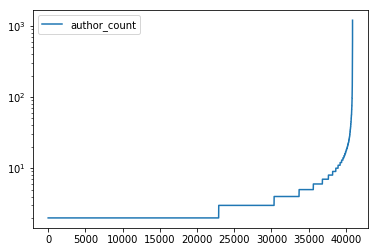

In [345]:
# Took this out: WARNING: YOU ARE USING PyCollabs BELOW, SO NEED TO MANUALLY UPDATE THIS IN BIGQUERY
# Upload project batch into my own table
pbatch_df.to_gbq(mydataset_name + '.PyCollabs',
                  'trans-scheme-206405', if_exists='replace')
pbatch_dfs = pbatch_df.sort_values(by='author_count').reset_index().drop(columns='index')
print(pbatch_dfs.shape)
pbatch_dfs.plot(y='author_count', logy=True)

In [ ]:
n_collabs = pbatch_dfs.shape[0]

In [5]:
# Get random project sample
# sample_size = 5000
# n_collabs = pbatch_dfs.shape[0]
proj_sample_query = """
SELECT collabs.project_id, commits.author_id, commits.created_at
FROM `{1}` collabs
JOIN `{0}.commits` commits
ON collabs.project_id = commits.project_id
AND EXTRACT(YEAR FROM commits.created_at) >= 2017
""".format(ght_dataset_name, mydataset_name + '.PyNotCollabs') #, sample_size, n_collabs)
proj_sample_commits = ght_bq.query_to_pandas(proj_sample_query)

In [6]:
print(proj_sample_commits.shape)

(1890513, 3)


In [7]:
# Upload project batch into my own table
proj_sample_commits.to_gbq(mydataset_name + '.SampleCommitsCollab',
                           'trans-scheme-206405', if_exists='replace')

In [20]:
sample_commits_17_query = """
SELECT *
FROM `{0}.SampleCommitsCollab`
WHERE EXTRACT(YEAR FROM created_at) = 2017
""".format(mydataset_name)
sample_commits_17 = ght_bq.query_to_pandas(sample_commits_17_query)
sample_commits_17.to_gbq(mydataset_name + '.SampleCommits17',
                           'trans-scheme-206405', if_exists='replace')

sample_commits_18_query = """
SELECT *
FROM `{0}.SampleCommitsCollab`
WHERE EXTRACT(YEAR FROM created_at) = 2018
""".format(mydataset_name)
sample_commits_18 = ght_bq.query_to_pandas(sample_commits_18_query)
sample_commits_18.to_gbq(mydataset_name + '.SampleCommits18',
                           'trans-scheme-206405', if_exists='replace')

In [21]:
authcounts17_query = """
SELECT project_id, author_id, COUNT(created_at) AS n_commits
FROM `{0}.SampleCommits17`
GROUP BY project_id, author_id
""".format(mydataset_name)
authcounts17 = ght_bq.query_to_pandas(authcounts17_query)
authcounts17.to_gbq(mydataset_name + '.AuthCounts17',
                           'trans-scheme-206405', if_exists='replace')

authcounts18_query = """
SELECT project_id, author_id, COUNT(created_at) AS n_commits
FROM `{0}.SampleCommits18`
GROUP BY project_id, author_id
""".format(mydataset_name)
authcounts18 = ght_bq.query_to_pandas(authcounts18_query)
authcounts18.to_gbq(mydataset_name + '.AuthCounts18',
                           'trans-scheme-206405', if_exists='replace')

In [22]:
print(authcounts17.shape)
authcounts17.sort_values(['project_id'], ascending=False).head(5)

(125461, 3)


project_id  author_id  n_commits
107687    93348889    3113211         19
17976     93209205    1201305          1
23324     93206190   31249077          1
12002     93204794     806033          1
15962     93202447    1636821          1

In [23]:
# Get max author for 2017
maxauth_query = """
SELECT auth17.project_id, auth17.author_id AS max_author, auth17.n_commits
FROM (SELECT project_id, MAX(n_commits) AS max_commits
FROM `{0}.AuthCounts17` GROUP BY project_id) maxtab
INNER JOIN `{0}.AuthCounts17` auth17
ON maxtab.project_id = auth17.project_id
AND maxtab.max_commits = auth17.n_commits
""".format(mydataset_name)
maxauths = ght_bq.query_to_pandas(maxauth_query)
# print('hello', maxauths.loc[maxauths['project_id'] == 2810242])
# print(maxauths.shape)
maxauths = maxauths.drop_duplicates(subset=['project_id'])
maxauths.to_gbq(mydataset_name + '.MaxAuths',
                           'trans-scheme-206405', if_exists='replace')

In [24]:
print(maxauths.shape)
maxauths.sort_values(by=['project_id'], ascending=False).head()

(125461, 3)


project_id  max_author  n_commits
108462    93348889     3113211         19
17976     93209205     1201305          1
23324     93206190    31249077          1
12002     93204794      806033          1
15962     93202447     1636821          1

In [26]:
sec_con_query17 = """
SELECT project_id, SUM(n_commits) n_sec_commits
FROM (SELECT auth17.project_id, auth17.author_id, auth17.n_commits
FROM `{0}.AuthCounts17` auth17
JOIN `{0}.MaxAuths` maxauths
ON auth17.project_id = maxauths.project_id
AND auth17.author_id <> maxauths.max_author)
GROUP BY project_id
""".format(mydataset_name)
sec_con17 = ght_bq.query_to_pandas(sec_con_query17)

In [27]:
sec_con17.head()

Empty DataFrame
Columns: [project_id, n_sec_commits]
Index: []

In [25]:
sec_con17.to_gbq(mydataset_name + '.SecCons17',
                           'trans-scheme-206405', if_exists='replace')

ZeroDivisionError: division by zero

In [ ]:
sec_con17.sort_values(by='n_sec_commits', ascending=True).head(30)

In [28]:
# Get 2018 secondary contributions
sec_con_query18 = """
SELECT mauths.project_id, IFNULL(sec_commits.n_sec_commits, 0) AS n_sec_commits
FROM (SELECT project_id, SUM(n_commits) n_sec_commits
FROM (SELECT auth18.project_id, auth18.author_id, auth18.n_commits
FROM `{0}.AuthCounts18` auth18
JOIN `{0}.MaxAuths` maxauths
ON auth18.project_id = maxauths.project_id
AND auth18.author_id <> maxauths.max_author)
GROUP BY project_id) sec_commits
RIGHT JOIN `{0}.MaxAuths` mauths
ON mauths.project_id = sec_commits.project_id
""".format(mydataset_name)
sec_con18 = ght_bq.query_to_pandas(sec_con_query18)
sec_con18.sort_values(by='project_id').head(5)

project_id  n_sec_commits
119381         253              0
59099          320              0
122796         407              1
124509         682              3
106749         962              0

In [29]:
sec_con18.to_gbq(mydataset_name + '.SecCons18',
                           'trans-scheme-206405', if_exists='replace')

In [38]:
commit_count_table['cloned'] = False # Will use this to track with columns are successfully cloned


In [34]:
commit_count_table.to_csv('saved_commit_count_table.csv')
commit_count_table.to_gbq(mydataset_name + '.MainCommitCounts',
                          'trans-scheme-206405', if_exists='append')

In [32]:
commit_count_table_query = """
SELECT maxauths.project_id AS project_id, projects.name, projects.url, maxauths.n_commits AS main_commits,
    0 AS sec_commits17, seccons18.n_sec_commits AS sec_commits18
FROM `{0}.MaxAuths` maxauths
/*JOIN `{0}.SecCons17` seccons17 ON maxauths.project_id = seccons17.project_id*/
JOIN `{0}.SecCons18` seccons18 ON maxauths.project_id = seccons18.project_id
JOIN `{1}.projects` projects ON maxauths.project_id = projects.id
""".format(mydataset_name, ght_dataset_name)
commit_count_table = ght_bq.query_to_pandas(commit_count_table_query)

In [33]:

print(commit_count_table.shape)
# commit_count_table = commit_count_table.sample(frac=1)
# commit_count_table.sort_values(by='sec_commits17',ascending=False).head()

(125461, 6)


In [9]:
with open('gh-token') as gh_token_file:
    gh_token = gh_token_file.read()

In [10]:
def convert_api_to_git_url(api_url):
    return api_url[0:8] + api_url[12:23] + api_url[29:] + ".git"

def insert_token(url_str, gtoken):
    return url_str[0:8] + gtoken + '@' + url_str[8:]

In [15]:
# Clone all repos not already cloned
limit = float('inf')
i = 0
existing_repos = os.listdir('repos')

In [ ]:
for index, row in commit_count_table.iterrows():
    if i >= limit:
        break
        
    dir_name = row['name'] + '_' + str(row['project_id'])
    if dir_name in existing_repos:
        print(dir_name + ' already cloned')
        commit_count_table.at[index, 'cloned'] = True

    else:
        print('Cloning: ' + dir_name)
        i += 1
        api_url = row['url']
        try:
            shortcut_url = insert_token(convert_api_to_git_url(api_url), gh_token)
#             print("\tActually cloning: " + shortcut_url)
            Repo.clone_from(shortcut_url, 'repos/' + dir_name)
            print("\tSuccessfully cloned " + dir_name)
            commit_count_table.at[index, 'cloned'] = True
            continue
            
        except Exception as error:
            print("\tShortcut failed to clone " + dir_name + ': ' + str(error))
            

In [18]:
# Mark all that are cloned
i = 0
for index, row in commit_count_table.iterrows():
    dir_name = row['name'] + '_' + str(row['project_id'])
    if dir_name in existing_repos:
#         print(dir_name + ' already cloned')
        commit_count_table.at[index, 'cloned'] = True
        i += 1
        
print("Total cloned:", i)

Total cloned: 4845


In [ ]:
# Send it to bigquery
commit_count_table.to_gbq(mydataset_name + '.MainCountsClonefs',
                          'trans-scheme-206405', if_exists='replace')

In [23]:
# Piece of code to quickly query a specific project ID
proj_id = 48735280
proj_query = """
SELECT * FROM `{0}.projects` WHERE id = {1}
""".format(ght_dataset_name, proj_id)
proj_lookup = ght_bq.query_to_pandas(proj_query)
proj_lookup.head(20)
#proj_lookup.iloc[0,1]

id                                                url  owner_id  \
0  48735280  https://api.github.com/repos/Clinical-Genomics...   3251129   

            name                           description language  \
0  clinical_EPPs  EPPs used in clinical genomics LIMS    Python   

                 created_at  forked_from  deleted                updated_at  \
0 2016-10-19 13:43:27+00:00     48735269    False 1970-01-02 00:00:00+00:00   

   forked_commit_id  
0         537649857

In [401]:
spec_commit_q = """
SELECT *
FROM `{0}.commits`
WHERE project_id = {1}
AND EXTRACT(YEAR FROM created_at) >= 2017
""".format(ght_dataset_name, proj_id)
proj_lookup = ght_bq.query_to_pandas(spec_commit_q)
print(proj_lookup.shape)
proj_lookup

(2, 6)


id                                       sha  author_id  \
0  708520591  1979a954d1fed74f871c9e748c160c80fb0d2f3d    4410930   
1  708539272  52f929bffeabbda332e67ba9ce30040c7cb1a21c     143014   

   committer_id  project_id                created_at  
0       4410930     2810242 2017-05-11 04:41:19+00:00  
1        143014     2810242 2017-06-05 15:19:54+00:00

In [302]:
test_query = """
SELECT project_id, COUNT(author_id) AS author_count
FROM `{0}.commits`
WHERE PROJECT_ID = {1}
GROUP BY project_id, author_id
""".format(ght_dataset_name, proj_id)
proj_lookup = ght_bq.query_to_pandas(test_query)
print(proj_lookup.shape)
proj_lookup

(1, 2)


project_id  author_count
0    59348788            10

In [87]:
spec_auth_count_q = """
SELECT project_id, COUNT(author_id)
FROM (SELECT *
FROM `{0}.commits`
WHERE project_id = {1})
GROUP BY project_id, author_id""".format(ght_dataset_name, proj_id)
proj_lookup = ght_bq.query_to_pandas(spec_auth_count_q)
proj_lookup.head(20)

project_id  f0_
0    11322850    2

In [5]:
future_dates_query = """
SELECT COUNT(*) FROM `{0}.commits`
WHERE CURRENT_TIMESTAMP() < created_at
""".format(ght_dataset_name)
weird_old_query = """
SELECT COUNT(*) FROM `{0}.commits`
WHERE created_at < TIMESTAMP('1990-01-01 00:00:00')
""".format(ght_dataset_name)
future_df = ght_bq.query_to_pandas(future_dates_query)
weird_old_df = ght_bq.query_to_pandas(weird_old_query)
print(future_df.head(),weird_old_df.head())

      f0_
0  119955        f0_
0  1027038


In [6]:
reasonable_dates_query = """
SELECT COUNT(*) FROM `{0}.commits`
WHERE CURRENT_TIMESTAMP() >= created_at
OR created_at >= TIMESTAMP('2005-04-07 00:00:00')
""".format(ght_dataset_name)
commits_df = ght_bq.query_to_pandas(reasonable_dates_query)
commits_df.head()

f0_
0  930401807

In [7]:
count_projects_q = "SELECT COUNT (*) FROM `{0}.projects`".format(ght_dataset_name)
count_projects_df = ght_bq.query_to_pandas(count_projects_q)
count_projects_df

f0_
0  83624114

In [8]:
count_proj_members_df = None
if os.path.isfile('count_proj_members.csv'):
    count_proj_members_df = pd.read_csv('count_proj_members.csv')
    
else:
    count_proj_members_q = """
    SELECT repo_id, COUNT(user_id) as n_members FROM `{0}.project_members`
    GROUP BY repo_id
    """.format(ght_dataset_name)
    count_proj_members_df = ght_bq.query_to_pandas(count_proj_members_q)
    count_proj_members_df.to_csv('count_proj_members.csv')

In [9]:
unnamed_cols = [col for col in count_proj_members_df.columns if col.find('Unnamed') != -1]
count_proj_members_df = count_proj_members_df.drop(unnamed_cols, 1)
count_proj_members_df.head()

repo_id  n_members
0  13417081          6
1  83463249          7
2  85639112          7
3  90697890          7
4  87889444          7

In [10]:
count_proj_members_df.shape

(6654055, 2)

In [11]:
large_proj_num = 400

In [12]:
big_proj_df = count_proj_members_df[count_proj_members_df['n_members'] >= large_proj_num]
len(big_proj_df)

244

In [13]:
bq_bigproj_dataset_name = 'BigProjDataset'
bq_bigproj_table_name = 'BigProjTable'

client = bigquery.Client()
dataset_ref = client.dataset(bq_bigproj_dataset_name)

In [14]:
dataset = bigquery.Dataset(dataset_ref)
try:
    dataset = client.create_dataset(dataset)
except:
    pass # No problem if it already exists

In [15]:
# table = bigquery.Table(bq_bigproj_dataset_name + '.' + bq_bigproj_table_name)
table_ref = dataset_ref.table(bq_bigproj_dataset_name)
table = bigquery.Table(table_ref)
try:
    table = client.create_table(table)
except:
    pass # No problem if it already exists

In [16]:
big_proj_df.to_gbq(bq_bigproj_dataset_name + '.' + bq_bigproj_table_name,
                  'trans-scheme-206405', if_exists='replace')

In [17]:
n_bigproj_q = "SELECT COUNT(*) FROM `BigProjDataset.BigProjTable`"
nbp_df = ght_bq.query_to_pandas(n_bigproj_q)
nbp_df

f0_
0  244

In [26]:
commit_df = None
if os.path.isfile('bigproj_commits.csv'):
    commit_df = pd.read_csv('bigproj_commits.csv')
else:
    commit_join_q = """
SELECT projects.id, projects.name, projects.owner_id, projects.language,
    projects.created_at as proj_created_at, projects.updated_at,
    commit_members.author_id as commit_author_id, commit_members.committer_id,
    commit_members.created_at as commit_created_at
    
FROM `{0}.projects` projects
JOIN (SELECT * FROM `BigProjDataset.BigProjTable` bigprojs
JOIN `{0}.commits` commits
ON bigprojs.repo_id = commits.project_id) commit_members

ON projects.id = commit_members.project_id
""".format(ght_dataset_name)
    commit_df = ght_bq.query_to_pandas(commit_join_q)
    commit_df.to_csv('bigproj_commits.csv')

In [27]:
print(commit_df.shape)
commit_df.head()

(370712, 10)


Unnamed: 0        id name  owner_id    language            proj_created_at  \
0           0  32620326   px   9369732  JavaScript  2015-09-24 17:19:14+00:00   
1           1  32620326   px   9369732  JavaScript  2015-09-24 17:19:14+00:00   
2           2  32620326   px   9369732  JavaScript  2015-09-24 17:19:14+00:00   
3           3  32620326   px   9369732  JavaScript  2015-09-24 17:19:14+00:00   
4           4  32620326   px   9369732  JavaScript  2015-09-24 17:19:14+00:00   

                  updated_at  commit_author_id  committer_id  \
0  1970-01-01 01:00:01+00:00           3998754       3998754   
1  1970-01-01 01:00:01+00:00           4736043       4736043   
2  1970-01-01 01:00:01+00:00           3045708       3045708   
3  1970-01-01 01:00:01+00:00           3045708       3045708   
4  1970-01-01 01:00:01+00:00            273572        273572   

           commit_created_at  
0  2016-08-30 03:42:58+00:00  
1  2016-02-23 18:36:37+00:00  
2  2017-07-10 17:47:40+00:00  
3  2017-04-25 20:33:10+00:00  
4  2016-06-23 23:41:47+00:00